In [3]:
import requests
from astropy.io import fits
from io import BytesIO
from astropy.io import fits
from astropy.visualization import simple_norm
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
from photutils.isophote import (Ellipse, EllipseGeometry,
                                build_ellipse_model)
from scipy.optimize import curve_fit

/home/marina/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Galáxia elíptica 

In [136]:
ra = 54.6210
dec = -35.4505
size = 200 # em pixels
pixscale = 0.50

url = (
    "https://www.legacysurvey.org/viewer/cutout.fits"
    f"?ra={ra}&dec={dec}"
    f"&layer=ls-dr10"      # <- aqui o 'ls-dr10'
    f"&pixscale={pixscale}"
    f"&size={size}"
    f"&bands=r"          # <- combinações possíveis: g, r, z, gr, gz, grz, etc.
)

response = requests.get(url)
response.raise_for_status()

print("Content-Type:", response.headers.get("Content-Type"))

# Agora deve ser um FITS válido
hdu = fits.open(BytesIO(response.content))
hdu.info()

data = hdu[0].data
header = hdu[0].header

Content-Type: image/fits
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (200, 200)   float32   


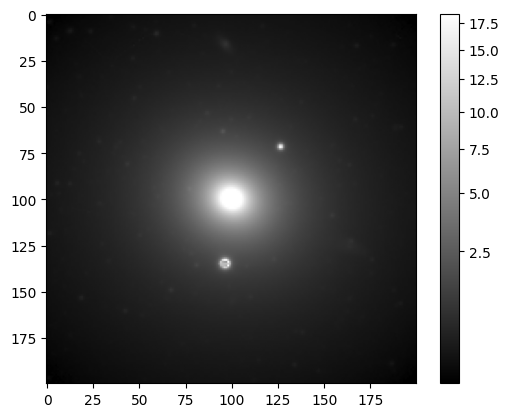

In [137]:
norm = simple_norm(data, 'sqrt', percent=99.5)
plt.imshow(data, norm=norm, cmap='gray')
plt.colorbar()
plt.show()

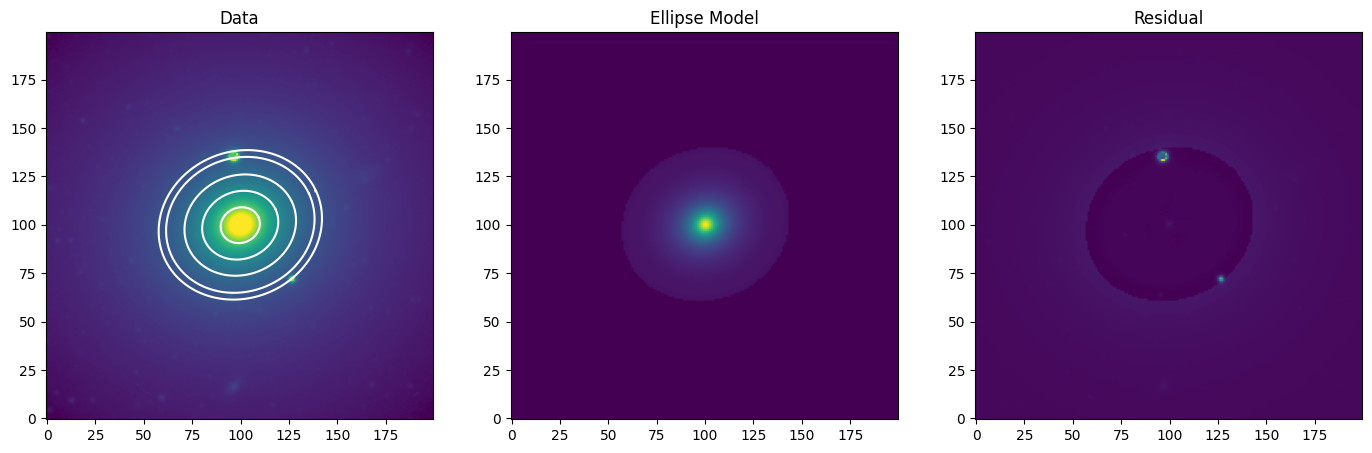

In [ ]:


# --- sua geometria inicial ---
geometry = EllipseGeometry(
    x0=data.shape[0]/2,
    y0=data.shape[1]/2,
    sma=20,
    eps=0.5,
    pa=20.0 * np.pi / 180.0)

ellipse = Ellipse(data, geometry)
isophote_list = ellipse.fit_image()

model_image = build_ellipse_model(data.shape, isophote_list)
residual = data - model_image

norm = simple_norm(data, 'sqrt', percent=99.5)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower',  norm=norm)
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isophote_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower')
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower')
ax3.set_title('Residual')

ax = plt.gca()


In [139]:
intensities = [iso.intens for iso in isophote_list]
sma = [iso.sma for iso in isophote_list]

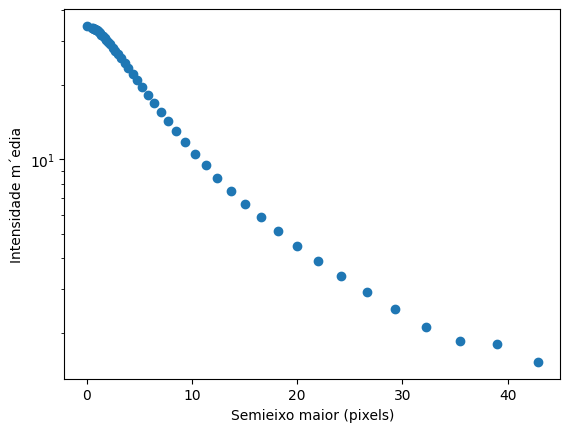

In [140]:
plt.semilogy(sma, intensities, 'o')
plt.xlabel("Semieixo maior (pixels)")
plt.ylabel("Intensidade m´edia")
plt.show()

In [161]:
sma_r = np.array([iso.sma for iso in isophote_list], dtype=float)
I = np.array(intensities, dtype=float)

# tira NaN, infinito e intensidades ≤ 0
mask_base = np.isfinite(sma_r) & np.isfinite(I) & (I > 0)

# escolha um range de raio razoável (ajuste isso na mão!)
rmin_pix = 5      # evita o centro PSF/saturado
rmax_pix = 40     # evita região muito ruidosa no extremo

mask_r = (sma_r >= rmin_pix) & (sma_r <= rmax_pix)

mask = mask_base & mask_r

r_fit = sma_r[mask]
I_fit = I[mask]


def sersic(R, Ie, Re, n):
    # aproximação padrão para b_n
    bn = 2.0 * n - 1.0/3.0
    return Ie * np.exp(-bn * ((R/Re)**(1.0/n) - 1.0))


Ie0 = np.median(I_fit[len(I_fit)//3 : 2*len(I_fit)//3])
Re0 = np.median(r_fit)
n0  = 4.0   # começar em de Vaucouleurs

p0 = [Ie0, Re0, n0]

# limitar n para algo razoável para elípticas
bounds = ([0.0, 0.0, 1.0],   # Ie > 0, Re > 0, n ≥ 1
          [np.inf, np.inf, 8.0])

popt_sersic, pcov = curve_fit(
    sersic, r_fit, I_fit,
    p0=p0, bounds=bounds, maxfev=10000
)

Ie_fit, Re_fit, n_fit = popt_sersic
print(f"Ie = {Ie_fit:.3g}")
print(f"Re = {Re_fit:.2f} pixels")
print(f"n  = {n_fit:.2f}")

def de_vaucouleurs(R, Ie, Re):
    return Ie * np.exp(-7.67*((R/Re)**0.25 - 1))

popt_deV, _ = curve_fit(
    de_vaucouleurs, r_fit, I_fit,
    p0=[Ie0, Re0], bounds=(0, np.inf), maxfev=10000
)

Ie = 1.81
Re = 34.99 pixels
n  = 2.29


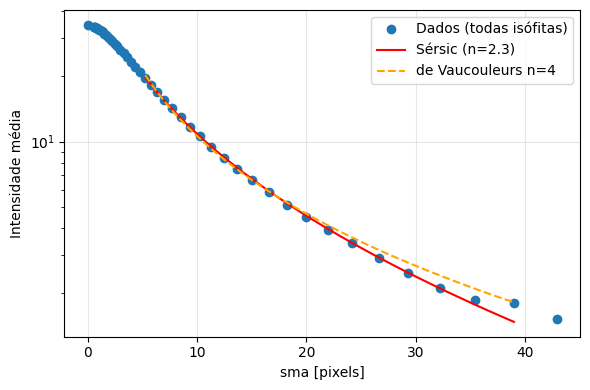

In [162]:
R_plot = np.linspace(r_fit.min(), r_fit.max(), 500)

I_sersic_fit = sersic(R_plot, *popt_sersic)
I_dev_fit    = de_vaucouleurs(R_plot, *popt_deV)  # opcional

plt.figure(figsize=(6,4))
plt.semilogy(sma_r, I, 'o', label="Dados (todas isófitas)")
plt.semilogy(R_plot, I_sersic_fit, 'r-', label=f"Sérsic (n={n_fit:.1f})")
plt.semilogy(R_plot, I_dev_fit, 'orange', linestyle='--', label="de Vaucouleurs n=4")

plt.xlabel("sma [pixels]")
plt.ylabel("Intensidade média")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Galáxia lenticular

In [53]:
ra = 186.5485
dec = 12.9460
size = 200 # em pixels
pixscale = 0.50

url = (
    "https://www.legacysurvey.org/viewer/cutout.fits"
    f"?ra={ra}&dec={dec}"
    f"&layer=ls-dr10"      # <- aqui o 'ls-dr10'
    f"&pixscale={pixscale}"
    f"&size={size}"
    f"&bands=r"          # <- combinações possíveis: g, r, z, gr, gz, grz, etc.
)

response = requests.get(url)
response.raise_for_status()

print("Content-Type:", response.headers.get("Content-Type"))

# Agora deve ser um FITS válido
hdu = fits.open(BytesIO(response.content))
hdu.info()

data = hdu[0].data
header = hdu[0].header

Content-Type: image/fits
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (200, 200)   float32   


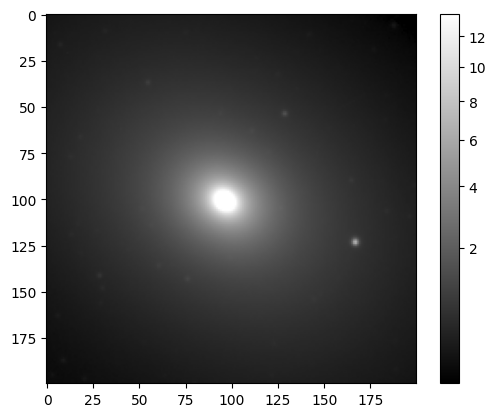

In [54]:
norm = simple_norm(data, 'sqrt', percent=99.5)
plt.imshow(data, norm=norm, cmap='gray')
plt.colorbar()
plt.show()

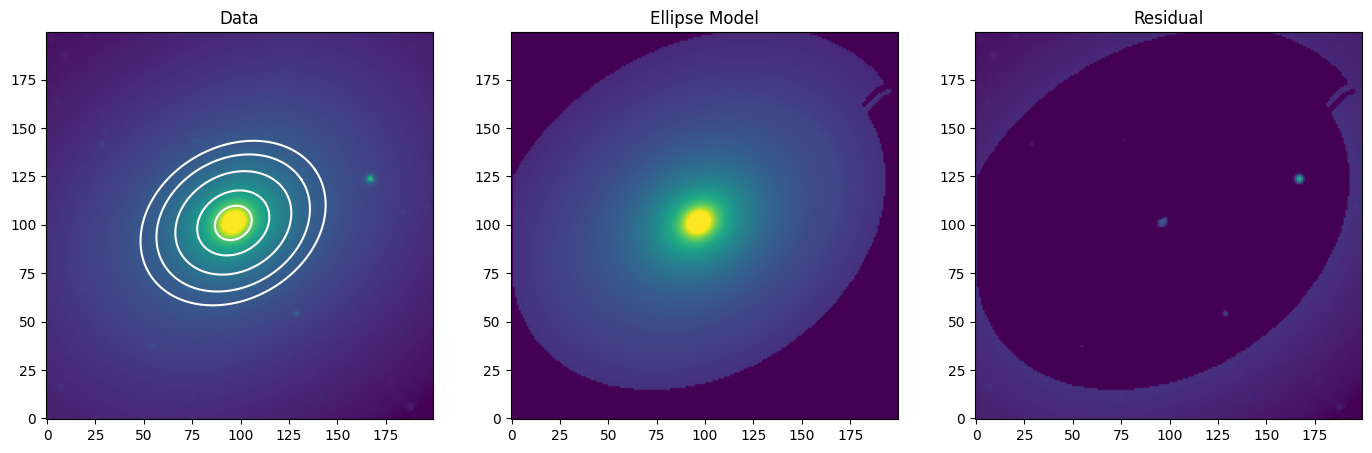

In [55]:
# --- sua geometria inicial ---
geometry = EllipseGeometry(
    x0=data.shape[0]/2,
    y0=data.shape[1]/2,
    sma=10,
    eps=0.5,
    pa=20.0 * np.pi / 180.0)

ellipse = Ellipse(data, geometry)
isophote_list = ellipse.fit_image()
#---- cria o modelo e resíduo ----
model_image = build_ellipse_model(data.shape, isophote_list)
residual = data - model_image
#plot de modelo, residuo e isófitas
norm = simple_norm(data, 'sqrt', percent=99.5)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower',  norm=norm)
ax1.set_title('Data')

smas = np.linspace(10, 50, 5)
for sma in smas:
    iso = isophote_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower', norm=norm)
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower', norm=norm)
ax3.set_title('Residual')

ax = plt.gca()


In [12]:
intensities = [iso.intens for iso in isophote_list]
sma = [iso.sma for iso in isophote_list]

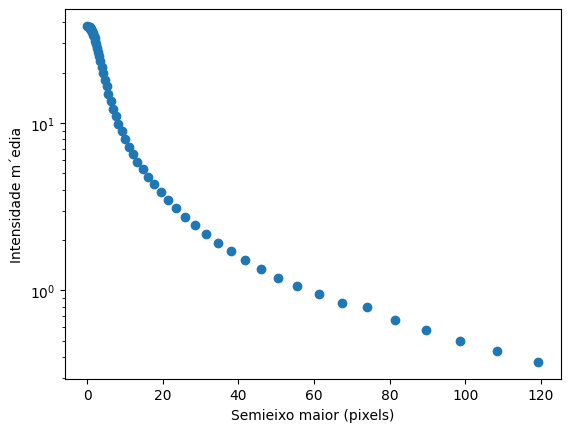

In [13]:
plt.semilogy(sma, intensities, 'o')
plt.xlabel("Semieixo maior (pixels)")
plt.ylabel("Intensidade m´edia")
plt.show()

In [19]:
sma_r = np.array([iso.sma for iso in isophote_list], dtype=float)
I = np.array(intensities, dtype=float)

# tira NaN, infinito e intensidades ≤ 0
mask_base = np.isfinite(sma_r) & np.isfinite(I) & (I > 0)

# escolha um range de raio razoável (ajuste isso na mão!)
rmin_pix = 5      # evita o centro PSF/saturado
rmax_pix = 80     # evita região muito ruidosa no extremo

mask_r = (sma_r >= rmin_pix) & (sma_r <= rmax_pix)

mask = mask_base & mask_r

r_fit = sma_r[mask]
I_fit = I[mask]

Ie0 = np.median(I_fit[len(I_fit)//3 : 2*len(I_fit)//3])
Re0 = np.median(r_fit)
n0  = 4.0   # começar em de Vaucouleurs

p0 = [Ie0, Re0, n0]

# limitar n para algo razoável para elípticas
bounds = ([0.0, 0.0, 1.0],   # Ie > 0, Re > 0, n ≥ 1
          [np.inf, np.inf, 8.0])

popt_sersic, pcov = curve_fit(
    sersic, r_fit, I_fit,
    p0=p0, bounds=bounds, maxfev=10000
)

Ie_fit, Re_fit, n_fit = popt_sersic
print(f"Ie = {Ie_fit:.3g}")
print(f"Re = {Re_fit:.2f} pixels")
print(f"n  = {n_fit:.2f}")

popt_deV, _ = curve_fit(
    de_vaucouleurs, r_fit, I_fit,
    p0=[Ie0, Re0], bounds=(0, np.inf), maxfev=10000
)

Ie = 0.00804
Re = 1061.60 pixels
n  = 8.00


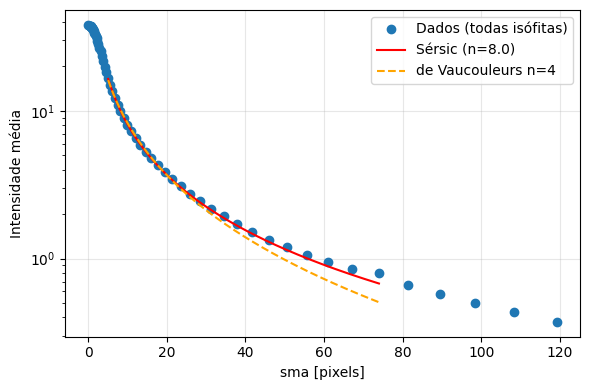

In [20]:
R_plot = np.linspace(r_fit.min(), r_fit.max(), 500)

I_sersic_fit = sersic(R_plot, *popt_sersic)
I_dev_fit    = de_vaucouleurs(R_plot, *popt_deV)  # opcional

plt.figure(figsize=(6,4))
plt.semilogy(sma_r, I, 'o', label="Dados (todas isófitas)")
plt.semilogy(R_plot, I_sersic_fit, 'r-', label=f"Sérsic (n={n_fit:.1f})")
plt.semilogy(R_plot, I_dev_fit, 'orange', linestyle='--', label="de Vaucouleurs n=4")

plt.xlabel("sma [pixels]")
plt.ylabel("Intensidade média")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Espirais

In [57]:


ra = 183.5271
dec = 14.7256
size = 400 # em pixels
pixscale = 0.50

url = (
    "https://www.legacysurvey.org/viewer/cutout.fits"
    f"?ra={ra}&dec={dec}"
    f"&layer=ls-dr10"      # <- aqui o 'ls-dr10'
    f"&pixscale={pixscale}"
    f"&size={size}"
    f"&bands=r"          # <- combinações possíveis: g, r, z, gr, gz, grz, etc.
)

response = requests.get(url)
response.raise_for_status()

print("Content-Type:", response.headers.get("Content-Type"))

# Agora deve ser um FITS válido
hdu = fits.open(BytesIO(response.content))
hdu.info()

data = hdu[0].data
header = hdu[0].header

Content-Type: image/fits
Filename: <class '_io.BytesIO'>
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      25   (400, 400)   float32   


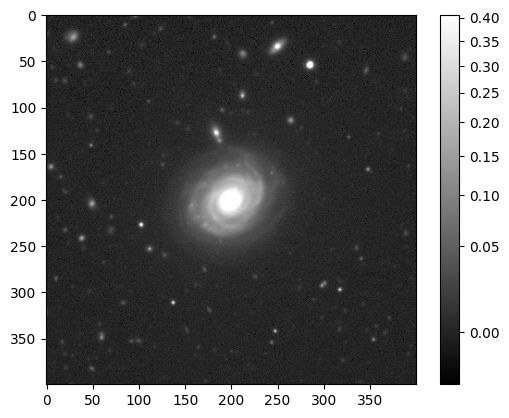

In [58]:
norm = simple_norm(data, 'sqrt', percent=99.5)
plt.imshow(data, norm=norm, cmap='gray')
plt.colorbar()
plt.show()

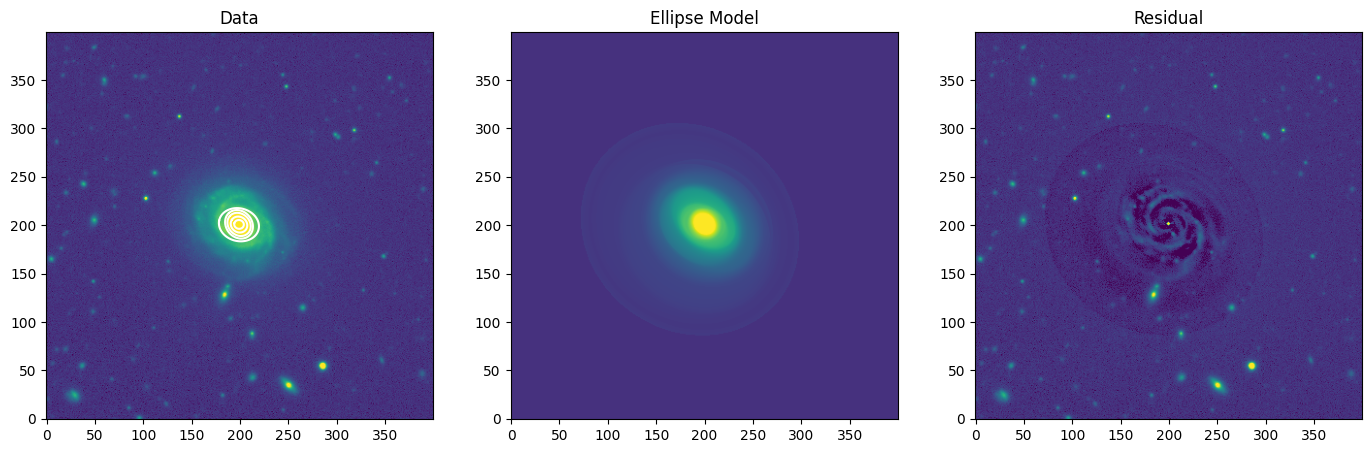

In [68]:
# --- sua geometria inicial ---
geometry = EllipseGeometry(
    x0=data.shape[0]/2,
    y0=data.shape[1]/2,
    sma=5,
    eps=0.55,
    pa=72 * np.pi / 180.0)

ellipse = Ellipse(data, geometry)
isophote_list = ellipse.fit_image()
#---- cria o modelo e resíduo ----
model_image = build_ellipse_model(data.shape, isophote_list)
residual = data - model_image
#plot de modelo, residuo e isófitas
norm = simple_norm(data, 'sqrt', percent=99.5)
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(14, 5), nrows=1, ncols=3)
fig.subplots_adjust(left=0.04, right=0.98, bottom=0.02, top=0.98)
ax1.imshow(data, origin='lower',  norm=norm)
ax1.set_title('Data')

smas = np.linspace(5, 20, 5)
for sma in smas:
    iso = isophote_list.get_closest(sma)
    x, y, = iso.sampled_coordinates()
    ax1.plot(x, y, color='white')

ax2.imshow(model_image, origin='lower', norm=norm)
ax2.set_title('Ellipse Model')

ax3.imshow(residual, origin='lower', norm=norm)
ax3.set_title('Residual')

ax = plt.gca()


In [60]:
intensities = [iso.intens for iso in isophote_list]
sma = [iso.sma for iso in isophote_list]

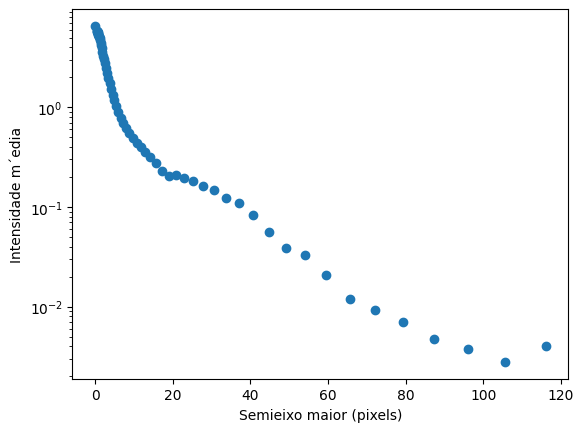

In [61]:
plt.semilogy(sma, intensities, 'o')
plt.xlabel("Semieixo maior (pixels)")
plt.ylabel("Intensidade m´edia")
plt.show()

In [62]:
sma_r = np.array([iso.sma for iso in isophote_list], dtype=float)
I = np.array(intensities, dtype=float)

# tira NaN, infinito e intensidades ≤ 0
mask_base = np.isfinite(sma_r) & np.isfinite(I) & (I > 0)

# escolha um range de raio razoável (ajuste isso na mão!)
rmin_pix = 5      # evita o centro PSF/saturado
rmax_pix = 20     # evita região muito ruidosa no extremo

mask_r = (sma_r >= rmin_pix) & (sma_r <= rmax_pix)

mask = mask_base & mask_r

r_fit = sma_r[mask]
I_fit = I[mask]

Ie0 = np.median(I_fit[len(I_fit)//3 : 2*len(I_fit)//3])
Re0 = np.median(r_fit)
n0  = 4.0   # começar em de Vaucouleurs

p0 = [Ie0, Re0, n0]

# limitar n para algo razoável para elípticas
bounds = ([0.0, 0.0, 1.0],   # Ie > 0, Re > 0, n ≥ 1
          [np.inf, np.inf, 8.0])

popt_sersic, pcov = curve_fit(
    sersic, r_fit, I_fit,
    p0=p0, bounds=bounds, maxfev=10000
)

Ie_fit, Re_fit, n_fit = popt_sersic
print(f"Ie = {Ie_fit:.3g}")
print(f"Re = {Re_fit:.2f} pixels")
print(f"n  = {n_fit:.2f}")

popt_deV, _ = curve_fit(
    de_vaucouleurs, r_fit, I_fit,
    p0=[Ie0, Re0], bounds=(0, np.inf), maxfev=10000
)

Ie = 0.00278
Re = 243.11 pixels
n  = 8.00


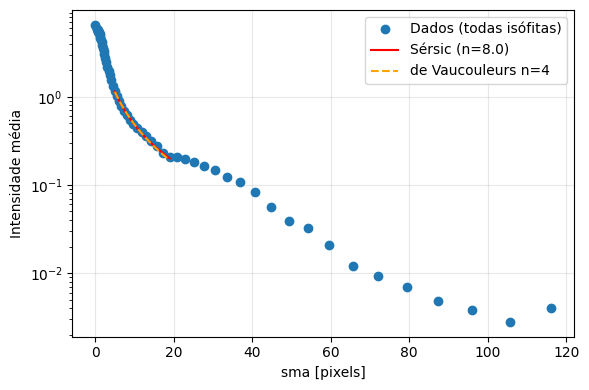

In [63]:
R_plot = np.linspace(r_fit.min(), r_fit.max(), 500)

I_sersic_fit = sersic(R_plot, *popt_sersic)
I_dev_fit    = de_vaucouleurs(R_plot, *popt_deV)  # opcional

plt.figure(figsize=(6,4))
plt.semilogy(sma_r, I, 'o', label="Dados (todas isófitas)")
plt.semilogy(R_plot, I_sersic_fit, 'r-', label=f"Sérsic (n={n_fit:.1f})")
plt.semilogy(R_plot, I_dev_fit, 'orange', linestyle='--', label="de Vaucouleurs n=4")

plt.xlabel("sma [pixels]")
plt.ylabel("Intensidade média")
plt.legend()
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()